In [1]:
#get notebook runtime
from timeit import default_timer as timer
start = timer()

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}



<IPython.core.display.Javascript object>

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

### Characteristics

Let's recall the characteristics of our dataset:

In [5]:
#get notebook runtime
start = timer()

In [6]:
df = pd.read_parquet("../data/df_cleaned_18_06_2021.parquet")

In [7]:
df.shape

(4328648, 33)

In [8]:
df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,PU_H3,DO_H3,PU_MONTH_NAME,PU_WEEKDAY_NAME,PU_YEAR,PU_MONTH,PU_WEEKDAY,PU_HOUR,PU_HOUR_OF_WEEK,PU_FOUR_HOURLY
10019694,0186acc0c8d50828e6dc5c9072ace58101e3e1b1,9a38858dc2ace73a20f89a976154131a733daf1f11e8d6...,2017-05-20 23:45:00,2017-05-20 23:45:00,360.0,1.30,1.703106e+10,1.703107e+10,6.0,7.0,...,872c2118bffffff,872c2118affffff,May,Saturday,2017,5,5,24,144,5/5
7792802,7d0830d9dbbd03a9e1b5d1d99cd41d99d7b8fb90,b4d59da1d7b8c002094752251906d9a3bcc6c7ea71a15f...,2017-04-21 22:15:00,2017-04-21 22:15:00,300.0,0.40,1.703108e+10,1.703108e+10,8.0,8.0,...,872c2119dffffff,872c2119dffffff,April,Friday,2017,4,4,23,119,5/5
7493958,171ea5e4956fe55a58f9ec3be65238af8b79c4c2,38c32bfda2f77c2a57f33a9e3fcf7edb8e996f59bc2254...,2017-04-18 10:30:00,2017-04-18 10:45:00,379.0,1.00,1.703184e+10,1.703128e+10,32.0,28.0,...,872c21191ffffff,872c2119cffffff,April,Tuesday,2017,4,1,11,35,3/5
5984763,a6da0037deae54685ba3a1a559ae6a33b9028bd9,e2c349c7cbb608d552aa0b5814031943f13641ef9e50d8...,2017-03-28 16:15:00,2017-03-28 16:15:00,317.0,0.96,1.703108e+10,1.703108e+10,8.0,8.0,...,872c2119cffffff,872c2119cffffff,March,Tuesday,2017,3,1,17,41,4/5
4498023,58bc23a32b790e568d3c50bc38e5dd473cbc9fcf,cbdd490649df25aa771979bed8930b199d27a990ccdb42...,2017-03-09 14:30:00,2017-03-09 14:30:00,360.0,1.00,1.703128e+10,1.703184e+10,28.0,32.0,...,872c2119cffffff,872c21191ffffff,March,Thursday,2017,3,3,15,87,3/5


In [9]:
df.isnull().sum()

Trip ID                             0
Taxi ID                          1477
Trip Start Timestamp                0
Trip End Timestamp                  0
Trip Seconds                        0
Trip Miles                          0
Pickup Census Tract           1303676
Dropoff Census Tract          1316214
Pickup Community Area          309000
Dropoff Community Area         392386
Fare                                0
Tips                                0
Tolls                         1138339
Extras                              0
Trip Total                          0
Payment Type                        0
Company                             0
Pickup Centroid Latitude       308810
Pickup Centroid Longitude      308810
Pickup Centroid Location       308810
Dropoff Centroid Latitude      379954
Dropoff Centroid Longitude     379954
Dropoff Centroid  Location     379954
PU_H3                          308810
DO_H3                          379954
PU_MONTH_NAME                       0
PU_WEEKDAY_N

In [10]:
df_pairplot = df[:100]

In [11]:
#sns.pairplot(df_pairplot, hue='PU_H3')

Nun schauen wir uns explizit die Korrelationen der Variablen an. Wie ebenfalls im vorigen Plot zu observieren, sehen wir hier, dass die Variablen zum Teil stark positiv sowie negativ korrelieren.

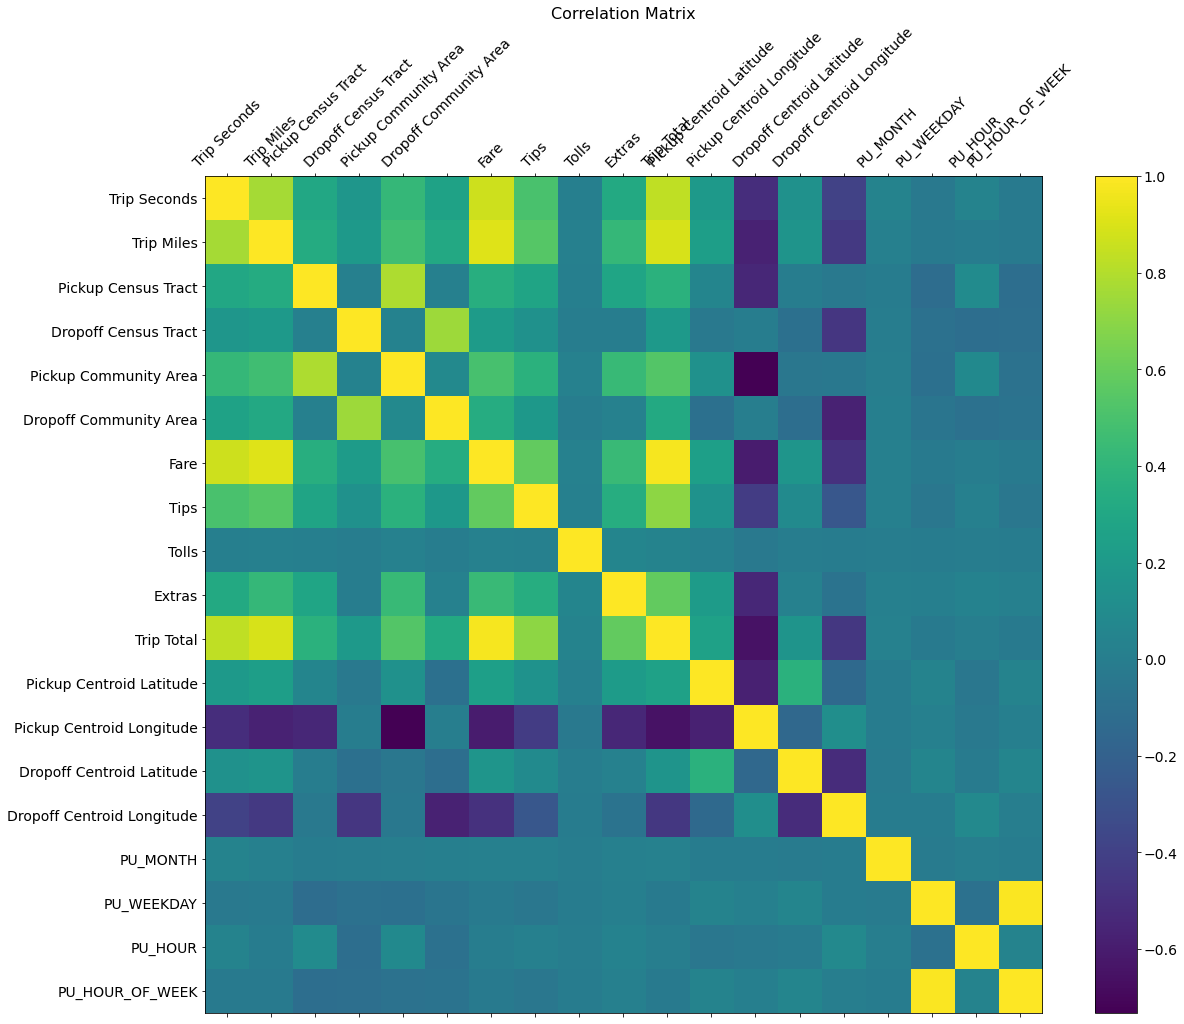

In [12]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Nun schauen wir uns die Verteilung unserer Zielvariablen taxi_demand (auf stündlicher basis) genauer an. Es ist zu erkennen, dass Samstags und Sonntags wesentlich häufiger früh am morgen das Taxi genutzt wird, als unter der Woche.

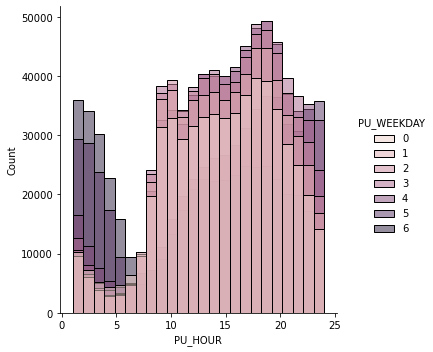

In [13]:
sns.displot(df,x='PU_HOUR', hue='PU_WEEKDAY', bins=24)


## 4. SVM

### Data Preparation for 4.1 SVM and 4.2 NN

Let's start with a reuseable function to get a dataframe of the selected temporal and spatial resolution. To obtain robust values for the predictors, we use the median.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR


In [15]:
#TODO: Felix input for feature selection

In [16]:
def get_data(df, temp_resolution):
    
    #group by spacial resolution
    df_new = df.groupby(pd.Grouper(key="Trip Start Timestamp", freq=temp_resolution)).median()
    df_new['count'] = df.groupby(pd.Grouper(key="Trip Start Timestamp", freq=temp_resolution))['Trip Start Timestamp'].count()
    df_new.dropna(inplace=True)
    
    
    '''#group by temporal and spacial resolution
    df_new = df.groupby(['PU_H3', pd.Grouper(key="Trip Start Timestamp", freq=temp_resolution)]).median()#create df based on temporal and spacial specifications
    df_new['count'] = df.groupby(['PU_H3', pd.Grouper(key="Trip Start Timestamp", freq=temp_resolution)]).size()#add demand for each unit of analysis; note that the frame is grouped by two features
    df_new.dropna(inplace=True)
    print("Dataframe after applying temporal and spacial specifications: ")#debug information
    print("Shape: ",df_new.shape)
    print("Demand description for temporal/spatial units (e.g. 2017-01-01 09:00, 8826641915fffff): ")
    print(df_new['count'].describe())
    
    #TODO - add spacial features to dataframe'''


    
    #select target and predictors
    y = df_new['count']
    X = df_new.drop('count', axis=1)
    print('Debug Information')
    print('-------------------------------')
    print("Shape Featureset/Target: ", X.shape, y.shape)
    print(X.iloc[0])
    
    #split data
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=38)
    
    #scale data
    scaler = StandardScaler()
    scaler.fit(x_train) #fit scaler
    X_train_scaled = scaler.transform(x_train) #apply to both, train and test set
    X_test_scaled = scaler.transform(x_test)
    print("Shape after scaling trainingset: ", X_train_scaled.shape, y_train.shape)
    print("Shape after scaling testset: ", X_test_scaled.shape, y_test.shape)
    
    #select best features
    selector = SelectKBest(f_classif, k=10)
    selector.fit(X_train_scaled, y_train)
    cols = selector.get_support(indices=True)#get selected columns
    X_train_new = X_train_scaled[:,cols]#apply to train&test set
    X_test_new = X_test_scaled[:,cols]
    print("X_Train:", X_train_new.shape, "X_Test:", X_test_new.shape)
    
    return X_train_new, X_test_new, y_train, y_test

### 4.1.1 SVM Prediction

First, we define a training method and to use it for training our models. Consequently, we will start with simple models and improve them for better performance. 

In [17]:
#function to train and evaluate our models later on
import sklearn.metrics as metrics
import numpy as np

def train(model, model_name, x_train, x_test, y_train, y_test, element):
    
    print()
    print(model_name, element) # Printing model name
    print('-------------------------------')
    model.fit(x_train,y_train) # fitting the defined model
    pred = model.predict(x_test) # predicting our data

    acc = metrics.r2_score(y_test, pred) #Checking R2_Score
    print('R2_Score',acc)

    met = np.sqrt(metrics.mean_squared_error(y_test, pred)) #Calculating RMSE
    print('RMSE : ', met) 

    var = (metrics.explained_variance_score(y_test, pred)) #Calculating explained_variance_score
    print('Explained_Variance : ', var)

    error = (metrics.max_error(y_test, pred)) #Calculating Max_Error
    print('Max_Error : ', error)
    
    err = metrics.mean_absolute_error(y_test, pred) #Calculating mean_absolute_error
    print("Mean Absolute Error", err)
    print()
    print()
    
    return model_name + '($R^2={:.3f}$)'.format(acc), np.array(y_test), pred

In [18]:
#select data to start with, we use a daily level for our inital modeling 

X_train_new, X_test_new, y_train, y_test = get_data(df, temp_resolution="24H")

Debug Information
-------------------------------
Shape Featureset/Target:  (334, 19) (334,)
Trip Seconds                  5.590000e+02
Trip Miles                    1.700000e+00
Pickup Census Tract           1.703108e+10
Dropoff Census Tract          1.703108e+10
Pickup Community Area         8.000000e+00
Dropoff Community Area        8.000000e+00
Fare                          9.000000e+00
Tips                          0.000000e+00
Tolls                         0.000000e+00
Extras                        1.000000e+00
Trip Total                    1.050000e+01
Pickup Centroid Latitude      4.189960e+01
Pickup Centroid Longitude    -8.763397e+01
Dropoff Centroid Latitude     4.189960e+01
Dropoff Centroid Longitude   -8.764265e+01
PU_MONTH                      1.000000e+00
PU_WEEKDAY                    6.000000e+00
PU_HOUR                       9.000000e+00
PU_HOUR_OF_WEEK               1.530000e+02
Name: 2017-01-01 00:00:00, dtype: float64
Shape after scaling trainingset:  (200, 19) (200

In [19]:
#Start without a Kernel
results=[] #save results-tuple for visualization
model_svr = SVR()
results.append(train(model_svr, "SVR", X_train_new, X_test_new,
                     y_train, y_test, "24H" ))


SVR 24H
-------------------------------
R2_Score 0.009443340386288468
RMSE :  2254.9141522804957
Explained_Variance :  0.009732122116917541
Max_Error :  6184.970662593536
Mean Absolute Error 1863.3630028815776




In [20]:
#Make more complex
model_svr2 = SVR(kernel='linear')
results.append(train(model_svr2, "SVR_Linear", X_train_new, X_test_new,
                     y_train, y_test, "24H"))


SVR_Linear 24H
-------------------------------
R2_Score 0.2061890564871296
RMSE :  2018.593600920538
Explained_Variance :  0.2164048979051043
Max_Error :  6112.424216319405
Mean Absolute Error 1681.0624137439518




In [21]:
#TODO Hyperparameter Tuning

### 4.1.2 Model Evaluation (Visually)

In this section, we will examine the performance of our models more closely. For this, we will look at the visual characteristics of our predictions.

In [22]:
# Bessere Visualisierung einbauen

In [23]:
#Create a plot comparing multiple learners
def plot(results):
    # Using subplots to display the results on the same X axis
    fig, plts = plt.subplots(nrows=len(results), figsize=(8, 8))
    fig.canvas.set_window_title('Predicting Chicago')

    # Show each element in the plots returned from plt.subplots()
    for subplot, (title, y, y_pred) in zip(plts, results):
        # Configure each subplot to have no tick marks
        # (these are meaningless for the sample dataset)
        subplot.set_xticklabels(())
        subplot.set_yticklabels(())

        # Label the vertical axis
        subplot.set_ylabel('Taxi Demand')
        subplot.set_xlabel('Time')

        # Set the title for the subplot
        subplot.set_title(title)

        # Plot the actual data and the prediction
        subplot.plot(y, 'b', label='actual')
        subplot.plot(y_pred, 'r', label='predicted')
        
        # Shade the area between the predicted and the actual values
        subplot.fill_between(
            # Generate X values [0, 1, 2, ..., len(y)-2, len(y)-1]
            np.arange(0, len(y), 1),
            y,
            y_pred,
            color='r',
            alpha=0.2
        )

        # Mark the extent of the training data
        subplot.axvline(len(y) // 2, linestyle='--', color='0', alpha=0.2)

        # Include a legend in each subplot
        subplot.legend()

    # Let matplotlib handle the subplot layout
    fig.tight_layout()
    plt.show()
    plt.savefig('plot.png')
    plt.close()

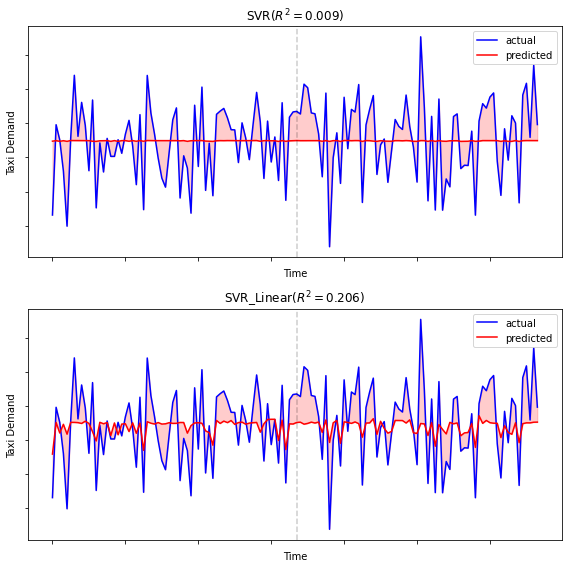

In [24]:
plot(results)

### 4.1.3 Variation of Temporal and Spatial Resolution

In this section, we aim to explore the performance of our best model based on a variation of termporal and spatial resolutions.

In [25]:
#TODO: Add Spatial Resolution

In [26]:
#TODO: Plot RMSE based on specifications

In [27]:
#generate datasets - temporal dimension
temporal_resolution_levels = ['24H', '6H', '2H', '1H']

results = []

for element in temporal_resolution_levels:
    model = SVR(kernel='linear')
    X_train_new, X_test_new, y_train, y_test = get_data(df, element)
    results.append(train(model, "SVR_Linear", X_train_new, X_test_new,
                         y_train, y_test, element))

end = timer()
print()
print("Total Notebook Runtime (s): ", end - start)

Debug Information
-------------------------------
Shape Featureset/Target:  (334, 19) (334,)
Trip Seconds                  5.590000e+02
Trip Miles                    1.700000e+00
Pickup Census Tract           1.703108e+10
Dropoff Census Tract          1.703108e+10
Pickup Community Area         8.000000e+00
Dropoff Community Area        8.000000e+00
Fare                          9.000000e+00
Tips                          0.000000e+00
Tolls                         0.000000e+00
Extras                        1.000000e+00
Trip Total                    1.050000e+01
Pickup Centroid Latitude      4.189960e+01
Pickup Centroid Longitude    -8.763397e+01
Dropoff Centroid Latitude     4.189960e+01
Dropoff Centroid Longitude   -8.764265e+01
PU_MONTH                      1.000000e+00
PU_WEEKDAY                    6.000000e+00
PU_HOUR                       9.000000e+00
PU_HOUR_OF_WEEK               1.530000e+02
Name: 2017-01-01 00:00:00, dtype: float64
Shape after scaling trainingset:  (200, 19) (200

In [28]:
#77community areas
#866 census tracts (population between 0 - 10000)
#resolution 0-15, with 0 beeing the 

In [29]:
'''import h3

resolution = 1
#calculate new H3 based on specified resolution
df["PU_H3"] = df.apply(lambda x: h3.geo_to_h3(x["Pickup Centroid Latitude"], x['Pickup Centroid Longitude'],8),axis=1)
df["PU_H3"] = df["PU_H3"].replace("0",np.nan)
'''

'import h3\n\nresolution = 1\n#calculate new H3 based on specified resolution\ndf["PU_H3"] = df.apply(lambda x: h3.geo_to_h3(x["Pickup Centroid Latitude"], x[\'Pickup Centroid Longitude\'],8),axis=1)\ndf["PU_H3"] = df["PU_H3"].replace("0",np.nan)\n'